# NLP to determine Tweet Sentiment










# Overview

# Data

In [39]:
#import neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
import time
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import string
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import label_binarize

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# import libraries for imbalanced class 
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.over_sampling import SMOTE

# Objective: identify negative tweets

In [2]:
df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding= 'unicode_escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
# rename columns 
df.rename(columns={'tweet_text': 'text', 'emotion_in_tweet_is_directed_at': 'product', 
                   'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, inplace=True)

# clean sentiment value names
sentiment_replace = {'Positive emotion': 'positive', 'Negative emotion': 'negative'}
df.sentiment.replace(sentiment_replace, inplace=True)

In [4]:
df.isna().sum()

text            1
product      5802
sentiment       0
dtype: int64

There are many null values in the product column, however that column will be dropped since it is not useful in this analysis.

We also will start with just the positive and negative tweets so that we have a binary classifier, and we'll get back to the neutral tweets later.

In [5]:
df.sentiment.value_counts()

No emotion toward brand or product    5389
positive                              2978
negative                               570
I can't tell                           156
Name: sentiment, dtype: int64

In [6]:
corpus = df[(df.sentiment == 'positive') | (df.sentiment == 'negative')].drop('product', axis=1)
corpus.head()

,text,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,positive
2,@swonderlin Can not wait for #iPad 2 also. The...,positive
3,@sxsw I hope this year's festival isn't as cra...,negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,positive


In [7]:
corpus.sentiment.replace(('negative', 'positive'), (1, 0), inplace=True)
corpus.sentiment.value_counts(normalize=True)

0    0.839346
1    0.160654
Name: sentiment, dtype: float64

Because we are trying to filter out the negative tweets, we want to say that the negative tweets are 1 and positive tweets are 0..The data is heavily imbalanced towards positive tweets. We will have to keep that in mind when createing our model. 

## Modeling

Preprocessing/vectorizing

In order to make text data useable for training a model, the text needs to be vectorized by making each word that apears in the text a feature of that vector. The model can then learn which words imply a specific sentiment.

It is important to make sure that the computer doesn't count words that are slightly different, but have the same meaning, as different words. For example "word" and "words" will be considered different features in the vector, if we let it. A similar problem, is words with capital letters or punctuations.

Sklearns CountVectorizer will solve these problems.

In [8]:
# Define X, y
X = corpus['text'] # Tweet content is our feature
y = corpus['sentiment'] #binary target for negative and positive emotions

# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42) # split data into training and testing

In [9]:
cv = CountVectorizer()
cv_X_train = cv.fit_transform(X_train)
cv_X_test = cv.transform(X_test)
df_cv = pd.DataFrame(cv_X_train.toarray(), columns=cv.get_feature_names())

C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


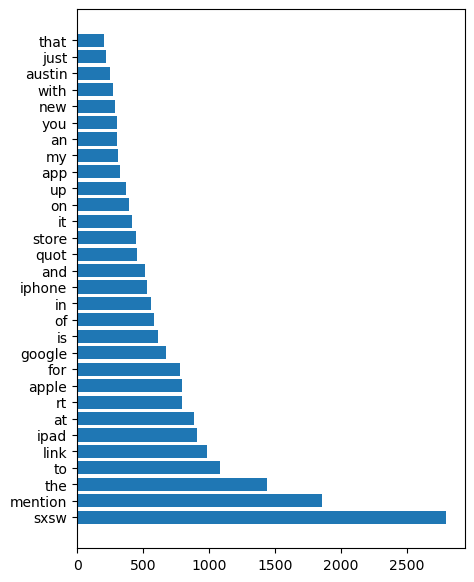

In [10]:
plt.figure(figsize=(5,7))
plt.barh(df_cv.sum().sort_values(ascending=False)[:30].index, df_cv.sum().sort_values(ascending=False)[:30]);

Many of these are stopwords, which should be removed. 
The CountVectorizer from sklearn automatically preprocesses, and tokenizes the words

C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


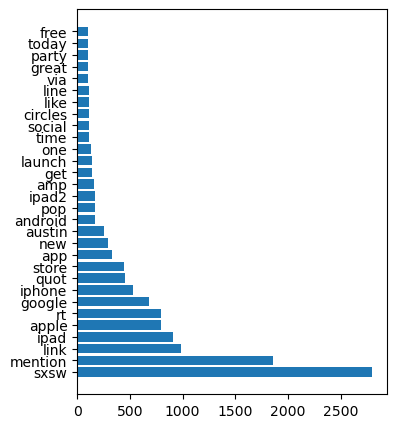

In [11]:
sw = stopwords.words('english')
sw_cv = CountVectorizer(stop_words=sw)
sw_cv_X_train = sw_cv.fit_transform(X_train)
sw_cv_X_test = sw_cv.transform(X_test)
sw_df_cv = pd.DataFrame(sw_cv_X_train.toarray(), columns=sw_cv.get_feature_names())
plt.figure(figsize=(4,5))
plt.barh(sw_df_cv.sum().sort_values(ascending=False)[:30].index, sw_df_cv.sum().sort_values(ascending=False)[:30]);

Start with a baseline model which will blindly predict half positive half negative.



C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


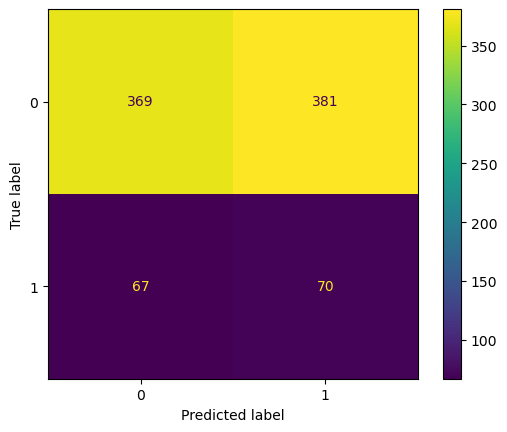

In [12]:
dummy = DummyClassifier(strategy='uniform', random_state=42)

dummy.fit(cv_X_train, y_train)
y_pred_dummy_sm = dummy.predict(cv_X_test)
plot_confusion_matrix(estimator=dummy, X=cv_X_test, y_true=y_test);

Naive Bayes is the simplest and fastest classification algorithm for a large chunk of data. In various applications such as spam filtering, text classification, sentiment analysis, and recommendation systems, Naive Bayes classifier is used successfully. It uses the Bayes probability theorem for unknown class prediction.

We know that getting a high accuracy will not be difficult because of the class imbalance which we noted earlier. The model will take in to acount the priors of each class and lean heavily towards positive classification. But it won't be able to identify the negative tweets very well.

This can be fixed by adjusting the priors of the algorithm. A grid search will find the priors that get the best recall score. Below is a function to do this grid search and print the results.

In [30]:
def mnb(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {'class_prior': [[0.5,0.5],[0.45,0.55],[0.4,0.6],[0.35,0.65], [0.3,0.7],[0.25,0.75]]}
    
    # Instantiate MultinomialNB model 
    mnb = MultinomialNB()
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=mnb, param_grid=grid, cv=cv, scoring='recall')
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    print(f'Best parameters: {gs.best_params_}')
    
    # Create prediction variable using test data
    y_pred = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv)
    print(f'Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    score = gs.score(X_test, y_test)
    print(f'Test f1: {score}')
    recall = recall_score(y_test, y_pred)
    print(f'Recall Score: {recall}')
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy score Score: {accuracy}')
    precision = precision_score(y_test, y_pred)
    print(f'Precision score: {precision}')
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots(figsize= (2, 4))
    plot_roc_curve(gs, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(gs, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    fig, ax = plt.subplots(figsize= (3, 3))
    plot_confusion_matrix(gs, X_test, y_test, ax=ax)
    return {'Accuracy': round(100*accuracy,1), 'Sensitivity': round(100*recall,1)}

Best parameters: {'class_prior': [0.25, 0.75]}
Cross-Val Score: 0.5960438385458434
Test f1: 0.5474452554744526
Recall Score: 0.5474452554744526
Accuracy score Score: 0.85456595264938
Precision score: 0.528169014084507


C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will 

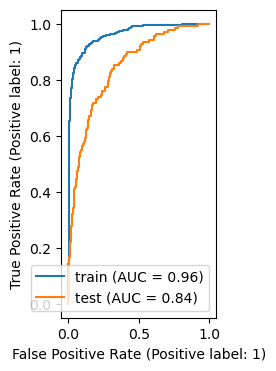

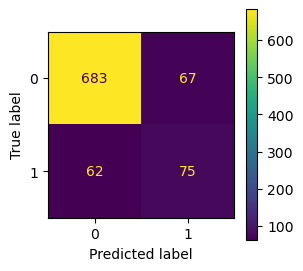

In [31]:
cv_mnb_results = mnb(cv_X_train, cv_X_test, y_train, y_test)

SMOTE. This produces duplicates of the minority class to even out the classes. Then run the model again.

In [15]:
smote = SMOTE(sampling_strategy='auto',random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(cv_X_train, y_train) 
# notice the class imbalance is corrected
y_train_sm.value_counts()

0    2228
1    2228
Name: sentiment, dtype: int64

Best parameters: {'class_prior': [0.25, 0.75]}
Cross-Val Score: 0.8766614601703028
Test f1: 0.656934306569343
Recall Score: 0.656934306569343
Accuracy score Score: 0.8196166854565953
Precision score: 0.4433497536945813


C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will 

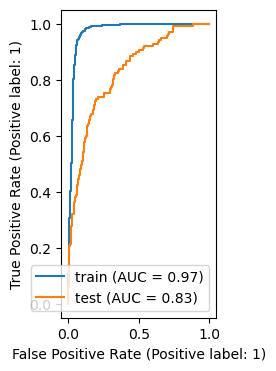

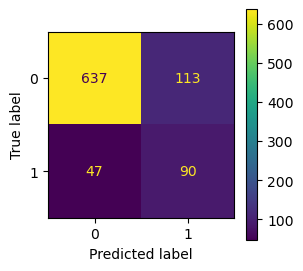

In [32]:
cv_mnb_sm_results = mnb(X_train_sm, cv_X_test, y_train_sm, y_test)

The accuracy went down, but for our purposes this is better results because we are much better at identifying the negative tweets.

We can try a more sophisticated vectorizer, which may improve the results. We'll try it with and without the SMOTE. Also try using different classifying algorithms.

In [34]:
tfidf = TfidfVectorizer(stop_words=sw)
tfidf_X_train = tfidf.fit_transform(X_train)
tfidf_X_test = tfidf.transform(X_test)
smote2 = SMOTE(sampling_strategy='auto',random_state=42)
X_train_sm2, y_train_sm2 = smote.fit_resample(tfidf_X_train, y_train)

Best parameters: {'class_prior': [0.25, 0.75]}
Cross-Val Score: 0.8521785618818498
Test f1: 0.7956204379562044
Recall Score: 0.7956204379562044
Accuracy score Score: 0.7181510710259301
Precision score: 0.3293051359516616


C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will 

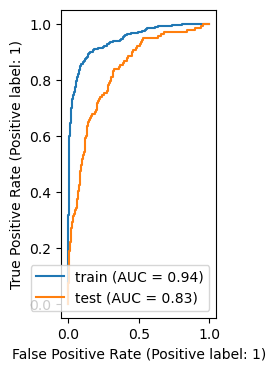

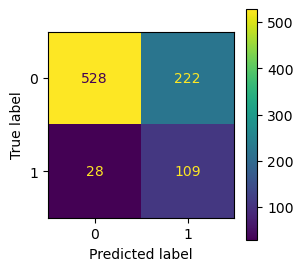

In [35]:
# without the SMOTE
tfidf_mnb_results = mnb(tfidf_X_train, tfidf_X_test, y_train, y_test)

Best parameters: {'class_prior': [0.25, 0.75]}
Cross-Val Score: 0.9977558321156849
Test f1: 0.9124087591240876
Recall Score: 0.9124087591240876
Accuracy score Score: 0.5862457722660653
Precision score: 0.2604166666666667


C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will 

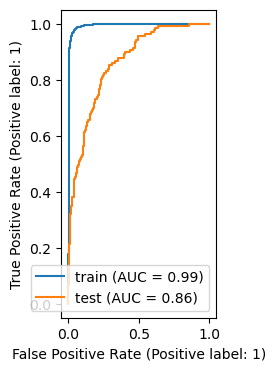

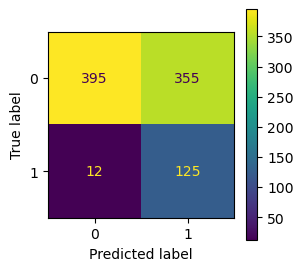

In [36]:
# with SMOTE
tfidf_mnb_sm_results = mnb(X_train_sm2, tfidf_X_test, y_train_sm2, y_test)

Random forest model

In [ ]:
def random_forest(X_train, X_test, y_train, y_test):
    
    # The number of features to consider when looking for the best split
    n_estimators = [75,100,125]
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Create the random grid
    grid = {'n_estimators': n_estimators,
                'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
    
    # Instantiate random forest classifier 
    rf = RandomForestClassifier()
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=rf, param_grid=grid, cv=5, scoring='recall')
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    print(f'Best parameters: {gs.best_params_}')
    
    # Create prediction variable using test data
    y_pred = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=5)
    print(f'Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    score = gs.score(X_test, y_test)
    print(f'Test f1: {score}')
    recall = recall_score(y_test, y_pred)
    print(f'Recall Score: {recall}')
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy score Score: {accuracy}')
    precision = precision_score(y_test, y_pred)
    print(f'Precision score: {precision}')
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(gs, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(gs, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_test, y_test)
    
    return {'Accuracy': round(100*accuracy,1), 'Sensitivity': round(100*recall,1)}

In [41]:
# Random Forest with the CountVectorizer
start = time.time()
cv_rf_results = random_forest(X_train_sm, cv_X_test, y_train_sm, y_test)
print('Execution time = %.6f seconds' % (time.time()-start))

Best parameters: {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 125}


KeyboardInterrupt: 

In [ ]:
# Random Forest with the TF-IDF Vectorizer
tfidf_rf_results = random_forest(X_train_sm2, tfidf_X_test, y_train_sm2, y_test)

# Results


In [ ]:
print(cv_mnb_results) 
print(cv_mnb_sm_results) 
print(tfidf_mnb_results)
print(tfidf_mnb_sm_results)
print(cv_rf_results)
print(tfidf_rf_results)

In [ ]:
models = ['cv_mnb_results', 'cv_mnb_sm_results', 'tfidf_mnb_results', 
          'tfidf_mnb_sm_results', 'cv_rf_results', 'tfidf_rf_results']
accuracies = [81, 73, 72, 59, 75, 88]
sensitivities = [61, 69, 80, 91, 69, 26]
X_axis = np.arange(len(models))
  
plt.figure(figsize=(14,8))
plt.bar(X_axis - 0.2, accuracies, 0.4, label = 'Accuracy')
plt.bar(X_axis + 0.2, sensitivities, 0.4, label = 'Sensitivity')
plt.xticks(X_axis, models)
plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Scores for Models")
plt.legend()
plt.show()

# Conclusions
